In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [197]:
df = pd.read_csv('data/StudentPerformanceFactors.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   object
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  Teacher_Quality             6529 non-null   object
 12  School_Type                 6607 non-null   object
 13  Peer_Influence              6607 non-null   obje

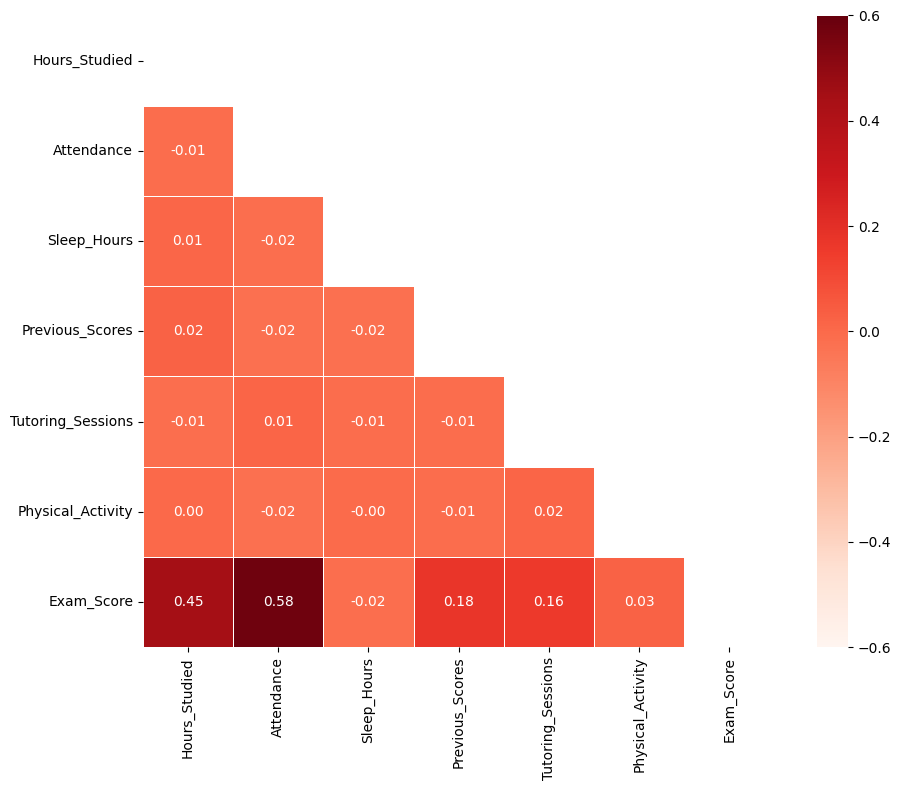

In [229]:
corr_matrix = df.select_dtypes(include='number').corr()

# Create mask for lower triangle
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

# Create the plot
plt.figure(figsize=(10, 8))

# Create heatmap
sns.heatmap(corr_matrix, 
            mask=mask,
            annot=True,
            fmt='.2f',
            cmap='Reds',  # Use red color scheme
            vmin=-0.6,    # Adjust color scale
            vmax=0.6,
            center=0,
            square=True,
            cbar_kws={'label': ''},
            linewidths=0.5)

# Customize the plot
plt.tight_layout()

plt.show()

In [199]:
class Preprocessing:
    def __init__(self):
        self.df = None
        self.train = None
        self.test = None

    def fit(self):
        self.df = self._drop_objects(self.df)
        self.df = self._random_nan(self.df)
        self.train, self.test = self._train_test_split(self.df)
        return self  

    def transform(self):
        return self.train, self.test

    def fit_transform(self, df):
        self.df = df
        self.fit()
        return self.transform()

    def _random_nan(self, _df: pd.DataFrame) -> pd.DataFrame:
        df = _df.copy()
        for i in range(df.shape[0]):
            j = np.random.choice(df.shape[1], 2, replace=False)
            df.iloc[i, j] = np.nan
        return df

    def _drop_objects(self, _df: pd.DataFrame) -> pd.DataFrame:
        return _df.select_dtypes(exclude=['object'])

    def _train_test_split(self, _df: pd.DataFrame, test_size=0.2) -> tuple:
        n = len(_df)
        idx = np.arange(n)
        np.random.shuffle(idx)
        train_idx = idx[int(n * test_size):]
        test_idx = idx[:int(n * test_size)]
        return _df.iloc[train_idx], _df.iloc[test_idx]

preprocessor = Preprocessing()
train, test = preprocessor.fit_transform(df)

In [200]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5286 entries, 5035 to 2656
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Hours_Studied      3739 non-null   float64
 1   Attendance         3749 non-null   float64
 2   Sleep_Hours        3804 non-null   float64
 3   Previous_Scores    3770 non-null   float64
 4   Tutoring_Sessions  3788 non-null   float64
 5   Physical_Activity  3769 non-null   float64
 6   Exam_Score         3811 non-null   float64
dtypes: float64(7)
memory usage: 330.4 KB


In [201]:
class Node:
    def __init__(self, f=None, t=None, l=None, r=None, v=None):
        self.f = f  # feature (split column)
        self.t = t  # threshold
        self.l = l  # left child
        self.r = r  # right child
        self.v = v  # value at leaf


class DecisionTreeRegressor:
    def __init__(self, min_split=2, min_leaf=1, max_depth=None):
        self.min_split = min_split
        self.min_leaf = min_leaf
        self.max_depth = max_depth
        self.root = None

    def fit(self, X, y):
        self.root = self._grow(X, y, d=0)
        return self

    def predict(self, X):
        return np.array([self._traverse(row, self.root) for _, row in X.iterrows()])

    def _grow(self, X: pd.DataFrame, y: pd.Series, d: int):
        n = len(y)

        if n < self.min_split or (self.max_depth is not None and d >= self.max_depth):
            return Node(v=self._leaf_val(y))

        f, t = self._best_split(X, y)

        if f is None:
            return Node(v=self._leaf_val(y))

        l_idx = X[f].isna() | (X[f] < t)
        r_idx = ~l_idx

        if l_idx.sum() < self.min_leaf or r_idx.sum() < self.min_leaf:
            return Node(v=self._leaf_val(y))

        l = self._grow(X[l_idx], y[l_idx], d + 1)
        r = self._grow(X[r_idx], y[r_idx], d + 1)
        return Node(f, t, l, r)

    def _traverse(self, row: pd.Series, n: Node):
        if n.v is not None:
            return n.v
        if pd.isna(row[n.f]):
            return self._traverse(row, n.l) 
        if row[n.f] < n.t:
            return self._traverse(row, n.l)
        return self._traverse(row, n.r)

    def _best_split(self, X: pd.DataFrame, y: pd.Series):
        best_gain = -np.inf
        best_f = None
        best_t = None
        for f in X.columns:
            thresholds = X[f].dropna().unique()
            for t in thresholds:
                gain = self._gain(y, X[f], t)
                if gain > best_gain:
                    best_gain = gain
                    best_f = f
                    best_t = t
        return best_f, best_t

    def _leaf_val(self, y: pd.Series):
        return y.mean()

    def _gain(self, y: pd.Series, X_col: pd.Series, t):
        p_var = self._variance(y)

        l_idx = X_col.isna() | (X_col < t)
        r_idx = ~l_idx

        if l_idx.sum() == 0 or r_idx.sum() == 0:
            return 0

        n = len(y)
        n_l, n_r = l_idx.sum(), r_idx.sum()
        var_l, var_r = self._variance(y[l_idx]), self._variance(y[r_idx])
        c_var = (n_l / n) * var_l + (n_r / n) * var_r

        return p_var - c_var

    def _variance(self, y: pd.Series):
        return y.var()

In [ ]:
for i in range(1, 9):
    for j in range(1, 5):
        error_list = [[] for _ in range(len(test.columns))]
        for k in range(2, 5):
            for col_idx, col in enumerate(test.columns):
                X_train, y_train = train.drop(columns=col), train[col]
                y_train = y_train.dropna()
                X_train = X_train.loc[y_train.index]

                X_test, y_test = test.drop(columns=col), test[col]
                nan_indices = y_test.index[y_test.isna()]
                X_test = X_test.loc[nan_indices]

                model = DecisionTreeRegressor(max_depth=i, min_split=k, min_leaf=j)
                model.fit(X_train, y_train)

                y_pred = model.predict(X_test)
                y_true = df.loc[nan_indices, col]

                assert len(y_pred) == len(y_true), "Ukuran prediksi dan nilai asli tidak sesuai!"

                squared_error = (y_pred - y_true.values) ** 2
                error_list[col_idx] = squared_error

            rmse_per_feature = {
                test.columns[j]: np.sqrt(np.mean(error_list[j])).astype(float) for j in range(len(test.columns))
            }

            avg_rmse = np.mean(list(rmse_per_feature.values()))
            if avg_rmse < best_rmse:
                best_rmse = avg_rmse
                best_params = {'max_depth': i, 'min_split': k, 'min_leaf': j}

print(f"Best RMSE: {best_rmse}")
print(f"Best params: {best_params}")

Best RMSE: 4.949214840906349
Best params: {'max_depth': 5, 'min_split': 2, 'min_leaf': 4}


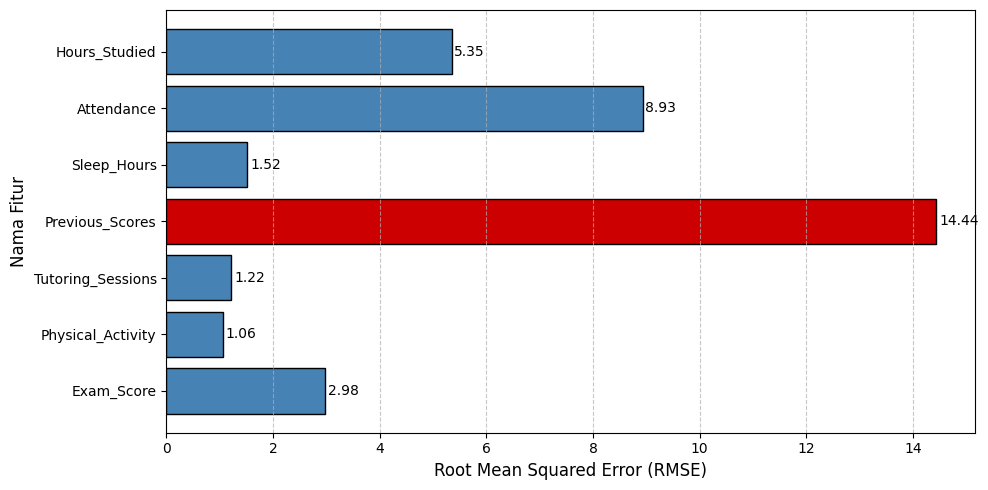

In [ ]:
plt.figure(figsize=(10, 5))
features = list(rmse_per_feature.keys())
rmse_values = list(rmse_per_feature.values())
bars = plt.barh(features, rmse_values, color=["steelblue" if val < 14 else "#cc0000" for val in rmse_values], edgecolor='black')

plt.xlabel('Root Mean Squared Error (RMSE)', fontsize=12)
plt.ylabel('Nama Fitur', fontsize=12)

plt.gca().invert_yaxis()  
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

for bar in bars:
    plt.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height() / 2,
             f"{bar.get_width():.2f}", va='center', fontsize=10)

plt.tight_layout()
plt.show()

In [214]:
error_list = [[] for _ in range(7)]
for col_idx, col in enumerate(test.columns):
    X_train, y_train = train.drop(columns=col), train[col]
    y_train = y_train.dropna()  
    X_train = X_train.loc[y_train.index]  

    X_test, y_test = test.drop(columns=col), test[col]
    nan_indices = y_test.index[y_test.isna()]  
    X_test = X_test.loc[nan_indices]  
    
    model = DecisionTreeRegressor()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)  
    y_true = df.loc[nan_indices, col]  
        
    squared_error = (y_pred - y_true.values) ** 2
    error_list[col_idx] = squared_error

rmse_per_feature = {
    test.columns[j]: np.sqrt(np.mean(error_list[j])).astype(float) for j in range(len(test.columns))
}

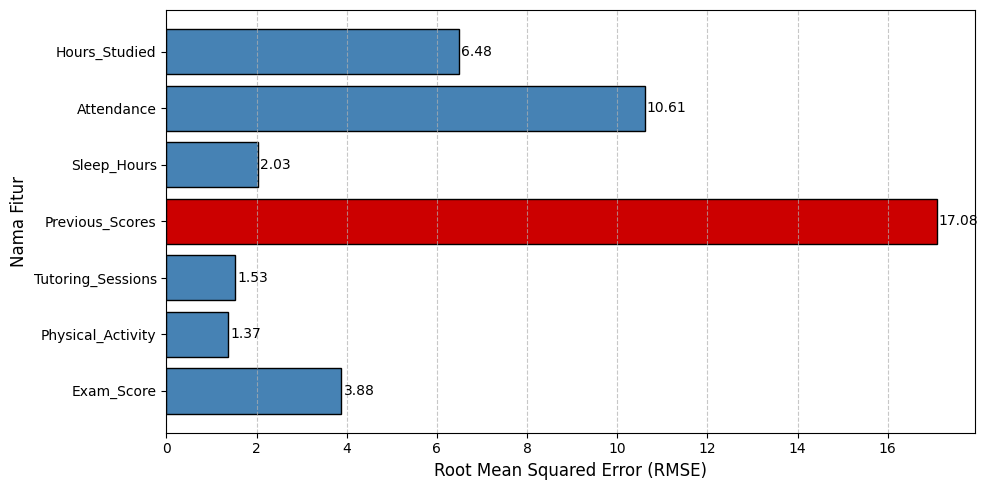

In [ ]:
plt.figure(figsize=(10, 5))
features = list(rmse_per_feature.keys())
rmse_values = list(rmse_per_feature.values())
bars = plt.barh(features, rmse_values, color=["steelblue" if val < 15 else "#cc0000" for val in rmse_values], edgecolor='black')

plt.xlabel('Root Mean Squared Error (RMSE)', fontsize=12)
plt.ylabel('Nama Fitur', fontsize=12)

plt.gca().invert_yaxis() y
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

for bar in bars:
    plt.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height() / 2,
             f"{bar.get_width():.2f}", va='center', fontsize=10)

plt.tight_layout()
plt.show()